# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

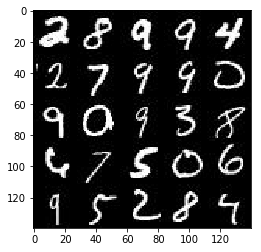

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

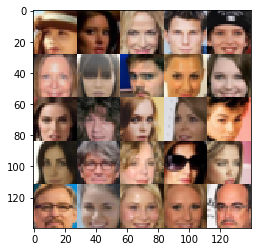

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input_images')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')
    
    return real_input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Define Custom Activation Function

In [6]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(x * alpha, x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [33]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # assume that images have shape 28x28x?
        
        layer1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        layer1_act = leaky_relu(layer1)
        # 14x14
        
        layer2 = tf.layers.conv2d(layer1_act, 256, 5, strides=2, padding='same')
        layer2_act = leaky_relu(layer2)
        # 7x7
        
        layer2_rs = tf.reshape(layer2_act, (-1, 7*7*256))
        
        logits = tf.layers.dense(layer2_rs, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        layer1 = tf.layers.dense(z, 7*7*256)
        layer1_rs = tf.reshape(layer1, (-1, 7, 7, 256))
        layer1_bn = tf.layers.batch_normalization(layer1_rs, training=is_train)
        layer1_act = leaky_relu(layer1_bn)
        # 7x7

        layer2 = tf.layers.conv2d_transpose(layer1_act, 128, 5, strides=2, padding='same')
        layer2_bn = tf.layers.batch_normalization(layer2, training=is_train)
        layer2_act = leaky_relu(layer2_bn)
        # 14x14
    
        logits = tf.layers.conv2d_transpose(layer2_act, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x?

        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [46]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    vars_ = tf.trainable_variables()
    g_vars = [var for var in vars_ if var.name.startswith('generator')]
    d_vars = [var for var in vars_ if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [47]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [48]:
import matplotlib.pyplot as plt

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100, figsize=(5,5)):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
                    
    
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 10 Discriminator Loss: 1.2264... Generator Loss: 0.6344
Epoch 1/2... Step 20 Discriminator Loss: 1.3134... Generator Loss: 0.7407
Epoch 1/2... Step 30 Discriminator Loss: 1.2471... Generator Loss: 0.8755
Epoch 1/2... Step 40 Discriminator Loss: 1.2378... Generator Loss: 0.8053
Epoch 1/2... Step 50 Discriminator Loss: 1.2305... Generator Loss: 0.7392
Epoch 1/2... Step 60 Discriminator Loss: 1.2242... Generator Loss: 0.9013
Epoch 1/2... Step 70 Discriminator Loss: 1.3183... Generator Loss: 1.1844
Epoch 1/2... Step 80 Discriminator Loss: 1.4494... Generator Loss: 0.4553
Epoch 1/2... Step 90 Discriminator Loss: 1.3555... Generator Loss: 1.1487
Epoch 1/2... Step 100 Discriminator Loss: 1.3491... Generator Loss: 0.6013


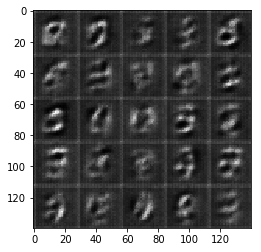

Epoch 1/2... Step 110 Discriminator Loss: 1.3505... Generator Loss: 0.6207
Epoch 1/2... Step 120 Discriminator Loss: 1.3114... Generator Loss: 0.8649
Epoch 1/2... Step 130 Discriminator Loss: 1.3318... Generator Loss: 0.7668
Epoch 1/2... Step 140 Discriminator Loss: 1.3206... Generator Loss: 0.6971
Epoch 1/2... Step 150 Discriminator Loss: 1.2896... Generator Loss: 0.8555
Epoch 1/2... Step 160 Discriminator Loss: 1.3479... Generator Loss: 1.1020
Epoch 1/2... Step 170 Discriminator Loss: 1.3132... Generator Loss: 0.7916
Epoch 1/2... Step 180 Discriminator Loss: 1.4726... Generator Loss: 0.4750
Epoch 1/2... Step 190 Discriminator Loss: 1.3227... Generator Loss: 0.7962
Epoch 1/2... Step 200 Discriminator Loss: 1.3514... Generator Loss: 0.7193


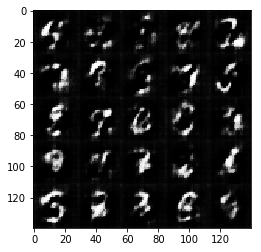

Epoch 1/2... Step 210 Discriminator Loss: 1.3414... Generator Loss: 0.7663
Epoch 1/2... Step 220 Discriminator Loss: 1.4331... Generator Loss: 0.6151
Epoch 1/2... Step 230 Discriminator Loss: 1.2921... Generator Loss: 0.7749
Epoch 1/2... Step 240 Discriminator Loss: 1.4195... Generator Loss: 0.6662
Epoch 1/2... Step 250 Discriminator Loss: 1.3373... Generator Loss: 0.9129
Epoch 1/2... Step 260 Discriminator Loss: 1.2693... Generator Loss: 0.9356
Epoch 1/2... Step 270 Discriminator Loss: 1.2843... Generator Loss: 0.8222
Epoch 1/2... Step 280 Discriminator Loss: 1.3217... Generator Loss: 0.9913
Epoch 1/2... Step 290 Discriminator Loss: 1.2702... Generator Loss: 0.8529
Epoch 1/2... Step 300 Discriminator Loss: 1.3012... Generator Loss: 0.8174


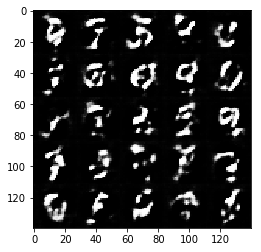

Epoch 1/2... Step 310 Discriminator Loss: 1.3937... Generator Loss: 0.5271
Epoch 1/2... Step 320 Discriminator Loss: 1.2862... Generator Loss: 0.8192
Epoch 1/2... Step 330 Discriminator Loss: 1.2588... Generator Loss: 0.9250
Epoch 1/2... Step 340 Discriminator Loss: 1.3962... Generator Loss: 1.3934
Epoch 1/2... Step 350 Discriminator Loss: 1.2236... Generator Loss: 0.9004
Epoch 1/2... Step 360 Discriminator Loss: 1.2855... Generator Loss: 0.8035
Epoch 1/2... Step 370 Discriminator Loss: 1.2884... Generator Loss: 0.6763
Epoch 1/2... Step 380 Discriminator Loss: 1.2551... Generator Loss: 0.7861
Epoch 1/2... Step 390 Discriminator Loss: 1.3480... Generator Loss: 0.5604
Epoch 1/2... Step 400 Discriminator Loss: 1.2495... Generator Loss: 0.8151


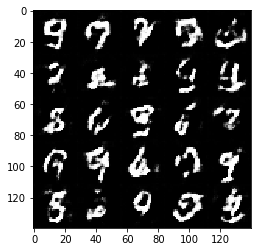

Epoch 1/2... Step 410 Discriminator Loss: 1.2578... Generator Loss: 1.0410
Epoch 1/2... Step 420 Discriminator Loss: 1.2522... Generator Loss: 0.9061
Epoch 1/2... Step 430 Discriminator Loss: 1.2376... Generator Loss: 1.1967
Epoch 1/2... Step 440 Discriminator Loss: 1.1936... Generator Loss: 1.0713
Epoch 1/2... Step 450 Discriminator Loss: 1.2370... Generator Loss: 1.2890
Epoch 1/2... Step 460 Discriminator Loss: 1.1891... Generator Loss: 1.0558
Epoch 2/2... Step 470 Discriminator Loss: 1.2131... Generator Loss: 1.0464
Epoch 2/2... Step 480 Discriminator Loss: 1.3026... Generator Loss: 1.3212
Epoch 2/2... Step 490 Discriminator Loss: 1.2206... Generator Loss: 0.8673
Epoch 2/2... Step 500 Discriminator Loss: 1.3915... Generator Loss: 1.5110


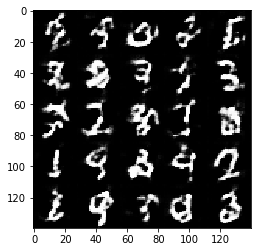

Epoch 2/2... Step 510 Discriminator Loss: 1.2697... Generator Loss: 0.8695
Epoch 2/2... Step 520 Discriminator Loss: 1.2517... Generator Loss: 0.7987
Epoch 2/2... Step 530 Discriminator Loss: 1.4214... Generator Loss: 0.5385
Epoch 2/2... Step 540 Discriminator Loss: 1.2808... Generator Loss: 0.9197
Epoch 2/2... Step 550 Discriminator Loss: 1.2623... Generator Loss: 1.0428
Epoch 2/2... Step 560 Discriminator Loss: 1.3366... Generator Loss: 1.1833
Epoch 2/2... Step 570 Discriminator Loss: 1.2569... Generator Loss: 0.9610
Epoch 2/2... Step 580 Discriminator Loss: 1.2969... Generator Loss: 0.7693
Epoch 2/2... Step 590 Discriminator Loss: 1.3594... Generator Loss: 0.6172
Epoch 2/2... Step 600 Discriminator Loss: 1.2740... Generator Loss: 0.7978


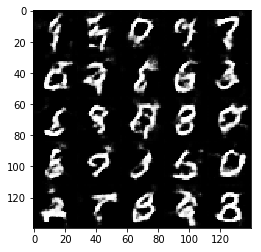

Epoch 2/2... Step 610 Discriminator Loss: 1.2781... Generator Loss: 0.9297
Epoch 2/2... Step 620 Discriminator Loss: 1.3184... Generator Loss: 1.2554
Epoch 2/2... Step 630 Discriminator Loss: 1.2807... Generator Loss: 0.8929
Epoch 2/2... Step 640 Discriminator Loss: 1.3048... Generator Loss: 0.6718
Epoch 2/2... Step 650 Discriminator Loss: 1.3703... Generator Loss: 0.5922
Epoch 2/2... Step 660 Discriminator Loss: 1.3051... Generator Loss: 0.8856
Epoch 2/2... Step 670 Discriminator Loss: 1.3228... Generator Loss: 1.0415
Epoch 2/2... Step 680 Discriminator Loss: 1.2697... Generator Loss: 0.9141
Epoch 2/2... Step 690 Discriminator Loss: 1.2982... Generator Loss: 0.7843
Epoch 2/2... Step 700 Discriminator Loss: 1.3517... Generator Loss: 0.6528


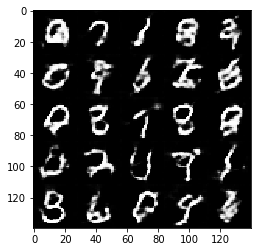

Epoch 2/2... Step 710 Discriminator Loss: 1.2958... Generator Loss: 0.7898
Epoch 2/2... Step 720 Discriminator Loss: 1.2813... Generator Loss: 1.0329
Epoch 2/2... Step 730 Discriminator Loss: 1.3589... Generator Loss: 0.8594
Epoch 2/2... Step 740 Discriminator Loss: 1.3093... Generator Loss: 1.0939
Epoch 2/2... Step 750 Discriminator Loss: 1.3248... Generator Loss: 0.8906
Epoch 2/2... Step 760 Discriminator Loss: 1.3666... Generator Loss: 0.9756
Epoch 2/2... Step 770 Discriminator Loss: 1.3009... Generator Loss: 1.1012
Epoch 2/2... Step 780 Discriminator Loss: 1.3383... Generator Loss: 1.0617
Epoch 2/2... Step 790 Discriminator Loss: 1.3003... Generator Loss: 0.9009
Epoch 2/2... Step 800 Discriminator Loss: 1.2896... Generator Loss: 0.7952


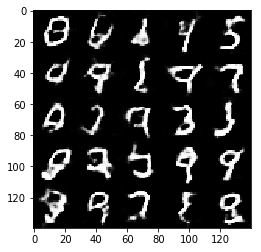

Epoch 2/2... Step 810 Discriminator Loss: 1.4107... Generator Loss: 0.5525
Epoch 2/2... Step 820 Discriminator Loss: 1.3050... Generator Loss: 0.9004
Epoch 2/2... Step 830 Discriminator Loss: 1.3056... Generator Loss: 0.7862
Epoch 2/2... Step 840 Discriminator Loss: 1.3436... Generator Loss: 0.6229
Epoch 2/2... Step 850 Discriminator Loss: 1.3088... Generator Loss: 0.7096
Epoch 2/2... Step 860 Discriminator Loss: 1.3718... Generator Loss: 0.6813
Epoch 2/2... Step 870 Discriminator Loss: 1.3485... Generator Loss: 0.6550
Epoch 2/2... Step 880 Discriminator Loss: 1.2983... Generator Loss: 0.8856
Epoch 2/2... Step 890 Discriminator Loss: 1.4208... Generator Loss: 1.0375
Epoch 2/2... Step 900 Discriminator Loss: 1.2859... Generator Loss: 0.8753


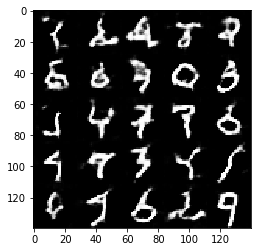

Epoch 2/2... Step 910 Discriminator Loss: 1.3278... Generator Loss: 0.7523
Epoch 2/2... Step 920 Discriminator Loss: 1.2966... Generator Loss: 0.9755
Epoch 2/2... Step 930 Discriminator Loss: 1.3056... Generator Loss: 0.9537


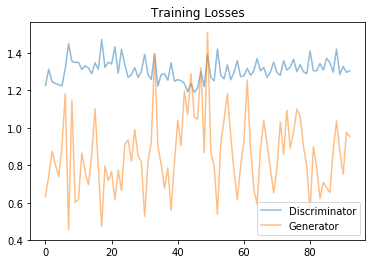

In [50]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10 Discriminator Loss: 1.1296... Generator Loss: 0.8770
Epoch 1/1... Step 20 Discriminator Loss: 1.0051... Generator Loss: 0.9978
Epoch 1/1... Step 30 Discriminator Loss: 1.0477... Generator Loss: 1.1358
Epoch 1/1... Step 40 Discriminator Loss: 1.2532... Generator Loss: 0.9523
Epoch 1/1... Step 50 Discriminator Loss: 1.2868... Generator Loss: 0.8671
Epoch 1/1... Step 60 Discriminator Loss: 1.2338... Generator Loss: 0.9667
Epoch 1/1... Step 70 Discriminator Loss: 1.2613... Generator Loss: 0.9553
Epoch 1/1... Step 80 Discriminator Loss: 1.2136... Generator Loss: 1.1776
Epoch 1/1... Step 90 Discriminator Loss: 1.2255... Generator Loss: 1.3283
Epoch 1/1... Step 100 Discriminator Loss: 1.2305... Generator Loss: 0.9631


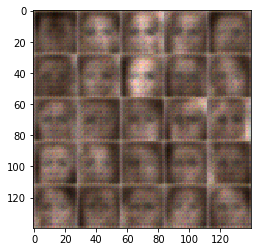

Epoch 1/1... Step 110 Discriminator Loss: 1.2306... Generator Loss: 0.7214
Epoch 1/1... Step 120 Discriminator Loss: 1.1867... Generator Loss: 0.9746
Epoch 1/1... Step 130 Discriminator Loss: 1.4126... Generator Loss: 0.5181
Epoch 1/1... Step 140 Discriminator Loss: 1.1491... Generator Loss: 0.9944
Epoch 1/1... Step 150 Discriminator Loss: 1.3643... Generator Loss: 0.6311
Epoch 1/1... Step 160 Discriminator Loss: 1.1663... Generator Loss: 0.9607
Epoch 1/1... Step 170 Discriminator Loss: 1.1641... Generator Loss: 1.3289
Epoch 1/1... Step 180 Discriminator Loss: 1.3224... Generator Loss: 0.8026
Epoch 1/1... Step 190 Discriminator Loss: 1.2597... Generator Loss: 0.7867
Epoch 1/1... Step 200 Discriminator Loss: 1.5015... Generator Loss: 0.4310


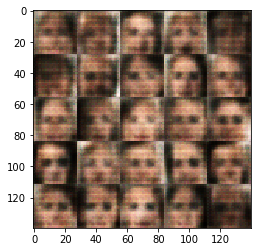

Epoch 1/1... Step 210 Discriminator Loss: 1.2046... Generator Loss: 1.0569
Epoch 1/1... Step 220 Discriminator Loss: 1.1337... Generator Loss: 0.8910
Epoch 1/1... Step 230 Discriminator Loss: 1.2373... Generator Loss: 1.7919
Epoch 1/1... Step 240 Discriminator Loss: 1.0709... Generator Loss: 1.0686
Epoch 1/1... Step 250 Discriminator Loss: 1.2711... Generator Loss: 0.7488
Epoch 1/1... Step 260 Discriminator Loss: 1.2332... Generator Loss: 1.3538
Epoch 1/1... Step 270 Discriminator Loss: 1.0176... Generator Loss: 1.3585
Epoch 1/1... Step 280 Discriminator Loss: 1.3130... Generator Loss: 0.8969
Epoch 1/1... Step 290 Discriminator Loss: 1.0459... Generator Loss: 1.2097
Epoch 1/1... Step 300 Discriminator Loss: 1.0815... Generator Loss: 0.9887


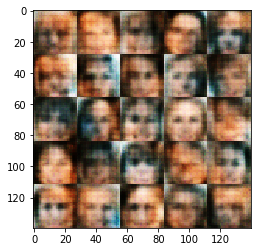

Epoch 1/1... Step 310 Discriminator Loss: 1.0400... Generator Loss: 0.9603
Epoch 1/1... Step 320 Discriminator Loss: 1.1016... Generator Loss: 0.9209
Epoch 1/1... Step 330 Discriminator Loss: 0.9740... Generator Loss: 1.1291
Epoch 1/1... Step 340 Discriminator Loss: 1.1099... Generator Loss: 1.1410
Epoch 1/1... Step 350 Discriminator Loss: 0.9627... Generator Loss: 1.1301
Epoch 1/1... Step 360 Discriminator Loss: 0.9339... Generator Loss: 1.4407
Epoch 1/1... Step 370 Discriminator Loss: 0.9947... Generator Loss: 1.2787
Epoch 1/1... Step 380 Discriminator Loss: 0.9469... Generator Loss: 1.7645
Epoch 1/1... Step 390 Discriminator Loss: 1.2334... Generator Loss: 0.8245
Epoch 1/1... Step 400 Discriminator Loss: 1.4010... Generator Loss: 0.6149


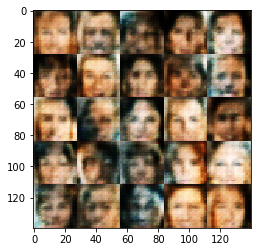

Epoch 1/1... Step 410 Discriminator Loss: 1.1535... Generator Loss: 1.2526
Epoch 1/1... Step 420 Discriminator Loss: 1.2221... Generator Loss: 0.7360
Epoch 1/1... Step 430 Discriminator Loss: 1.3941... Generator Loss: 0.5442
Epoch 1/1... Step 440 Discriminator Loss: 1.1979... Generator Loss: 1.1505
Epoch 1/1... Step 450 Discriminator Loss: 1.1110... Generator Loss: 1.2556
Epoch 1/1... Step 460 Discriminator Loss: 1.4977... Generator Loss: 0.4389
Epoch 1/1... Step 470 Discriminator Loss: 1.1967... Generator Loss: 0.6784
Epoch 1/1... Step 480 Discriminator Loss: 1.2605... Generator Loss: 0.6237
Epoch 1/1... Step 490 Discriminator Loss: 1.1206... Generator Loss: 0.8558
Epoch 1/1... Step 500 Discriminator Loss: 1.4644... Generator Loss: 0.5087


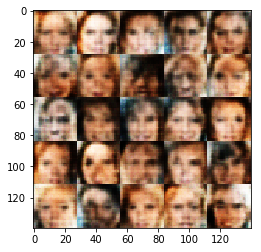

Epoch 1/1... Step 510 Discriminator Loss: 1.0119... Generator Loss: 1.1499
Epoch 1/1... Step 520 Discriminator Loss: 0.9760... Generator Loss: 1.2280
Epoch 1/1... Step 530 Discriminator Loss: 1.2663... Generator Loss: 0.7026
Epoch 1/1... Step 540 Discriminator Loss: 1.3492... Generator Loss: 0.6515
Epoch 1/1... Step 550 Discriminator Loss: 0.9405... Generator Loss: 1.6696
Epoch 1/1... Step 560 Discriminator Loss: 0.9781... Generator Loss: 1.2302
Epoch 1/1... Step 570 Discriminator Loss: 1.1682... Generator Loss: 1.5964
Epoch 1/1... Step 580 Discriminator Loss: 1.0098... Generator Loss: 1.3565
Epoch 1/1... Step 590 Discriminator Loss: 1.0220... Generator Loss: 0.9378
Epoch 1/1... Step 600 Discriminator Loss: 1.1261... Generator Loss: 0.9319


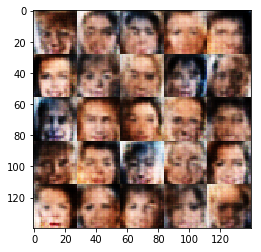

Epoch 1/1... Step 610 Discriminator Loss: 0.9308... Generator Loss: 1.3746
Epoch 1/1... Step 620 Discriminator Loss: 1.0841... Generator Loss: 1.5787
Epoch 1/1... Step 630 Discriminator Loss: 1.0294... Generator Loss: 0.9967
Epoch 1/1... Step 640 Discriminator Loss: 0.9537... Generator Loss: 1.4258
Epoch 1/1... Step 650 Discriminator Loss: 0.8691... Generator Loss: 1.6751
Epoch 1/1... Step 660 Discriminator Loss: 1.2096... Generator Loss: 1.2320
Epoch 1/1... Step 670 Discriminator Loss: 1.0092... Generator Loss: 0.9975
Epoch 1/1... Step 680 Discriminator Loss: 1.0233... Generator Loss: 1.3008
Epoch 1/1... Step 690 Discriminator Loss: 1.4705... Generator Loss: 0.4870
Epoch 1/1... Step 700 Discriminator Loss: 1.0597... Generator Loss: 1.1535


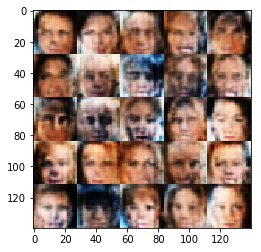

Epoch 1/1... Step 710 Discriminator Loss: 1.0221... Generator Loss: 1.0505
Epoch 1/1... Step 720 Discriminator Loss: 1.2812... Generator Loss: 0.7800
Epoch 1/1... Step 730 Discriminator Loss: 1.2389... Generator Loss: 0.8222
Epoch 1/1... Step 740 Discriminator Loss: 1.1599... Generator Loss: 0.9275
Epoch 1/1... Step 750 Discriminator Loss: 1.6328... Generator Loss: 0.3905
Epoch 1/1... Step 760 Discriminator Loss: 1.2235... Generator Loss: 0.8990
Epoch 1/1... Step 770 Discriminator Loss: 1.0881... Generator Loss: 1.0162
Epoch 1/1... Step 780 Discriminator Loss: 1.1612... Generator Loss: 1.0303
Epoch 1/1... Step 790 Discriminator Loss: 1.2859... Generator Loss: 0.8146
Epoch 1/1... Step 800 Discriminator Loss: 1.1985... Generator Loss: 1.0618


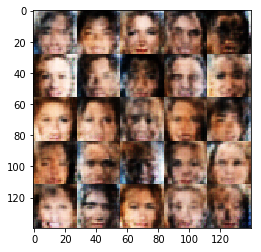

Epoch 1/1... Step 810 Discriminator Loss: 1.0695... Generator Loss: 1.0745
Epoch 1/1... Step 820 Discriminator Loss: 1.3366... Generator Loss: 0.6264
Epoch 1/1... Step 830 Discriminator Loss: 1.1357... Generator Loss: 1.1534
Epoch 1/1... Step 840 Discriminator Loss: 1.3030... Generator Loss: 0.6455
Epoch 1/1... Step 850 Discriminator Loss: 1.1637... Generator Loss: 1.0992
Epoch 1/1... Step 860 Discriminator Loss: 1.6423... Generator Loss: 0.4645
Epoch 1/1... Step 870 Discriminator Loss: 1.1487... Generator Loss: 0.9097
Epoch 1/1... Step 880 Discriminator Loss: 0.9971... Generator Loss: 1.2289
Epoch 1/1... Step 890 Discriminator Loss: 1.0088... Generator Loss: 1.1984
Epoch 1/1... Step 900 Discriminator Loss: 1.1656... Generator Loss: 0.8870


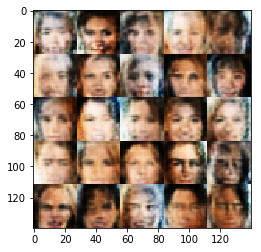

Epoch 1/1... Step 910 Discriminator Loss: 1.1076... Generator Loss: 1.0532
Epoch 1/1... Step 920 Discriminator Loss: 1.3347... Generator Loss: 0.7220
Epoch 1/1... Step 930 Discriminator Loss: 1.4010... Generator Loss: 0.8355
Epoch 1/1... Step 940 Discriminator Loss: 1.1513... Generator Loss: 1.0428
Epoch 1/1... Step 950 Discriminator Loss: 1.4270... Generator Loss: 0.5976
Epoch 1/1... Step 960 Discriminator Loss: 1.0700... Generator Loss: 1.0681
Epoch 1/1... Step 970 Discriminator Loss: 1.3477... Generator Loss: 0.8374
Epoch 1/1... Step 980 Discriminator Loss: 1.2082... Generator Loss: 1.0914
Epoch 1/1... Step 990 Discriminator Loss: 1.3453... Generator Loss: 1.0242
Epoch 1/1... Step 1000 Discriminator Loss: 1.1658... Generator Loss: 0.9015


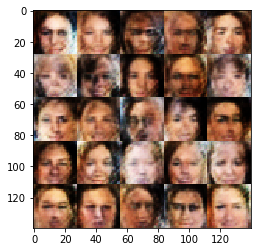

Epoch 1/1... Step 1010 Discriminator Loss: 1.0922... Generator Loss: 1.1969
Epoch 1/1... Step 1020 Discriminator Loss: 1.1395... Generator Loss: 1.0955
Epoch 1/1... Step 1030 Discriminator Loss: 1.0652... Generator Loss: 1.1665
Epoch 1/1... Step 1040 Discriminator Loss: 1.3204... Generator Loss: 0.9291
Epoch 1/1... Step 1050 Discriminator Loss: 1.3626... Generator Loss: 0.8578
Epoch 1/1... Step 1060 Discriminator Loss: 1.0646... Generator Loss: 1.0562
Epoch 1/1... Step 1070 Discriminator Loss: 1.2720... Generator Loss: 0.7222
Epoch 1/1... Step 1080 Discriminator Loss: 1.2534... Generator Loss: 0.9476
Epoch 1/1... Step 1090 Discriminator Loss: 1.3224... Generator Loss: 0.8870
Epoch 1/1... Step 1100 Discriminator Loss: 1.1615... Generator Loss: 0.9211


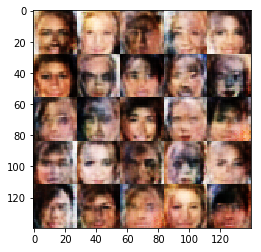

Epoch 1/1... Step 1110 Discriminator Loss: 1.1255... Generator Loss: 1.1567
Epoch 1/1... Step 1120 Discriminator Loss: 1.2714... Generator Loss: 0.8947
Epoch 1/1... Step 1130 Discriminator Loss: 1.3164... Generator Loss: 0.9583
Epoch 1/1... Step 1140 Discriminator Loss: 1.2383... Generator Loss: 0.8916
Epoch 1/1... Step 1150 Discriminator Loss: 1.1204... Generator Loss: 1.1053
Epoch 1/1... Step 1160 Discriminator Loss: 1.1732... Generator Loss: 0.8731
Epoch 1/1... Step 1170 Discriminator Loss: 1.1546... Generator Loss: 1.7897
Epoch 1/1... Step 1180 Discriminator Loss: 1.1895... Generator Loss: 1.0112
Epoch 1/1... Step 1190 Discriminator Loss: 1.2228... Generator Loss: 0.9772
Epoch 1/1... Step 1200 Discriminator Loss: 1.2489... Generator Loss: 0.8823


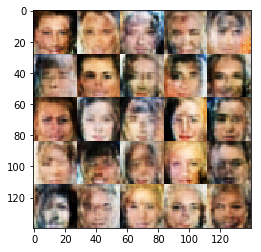

Epoch 1/1... Step 1210 Discriminator Loss: 1.3410... Generator Loss: 1.0377
Epoch 1/1... Step 1220 Discriminator Loss: 1.3073... Generator Loss: 0.8486
Epoch 1/1... Step 1230 Discriminator Loss: 1.3110... Generator Loss: 0.8573
Epoch 1/1... Step 1240 Discriminator Loss: 1.2261... Generator Loss: 1.0047
Epoch 1/1... Step 1250 Discriminator Loss: 1.1906... Generator Loss: 0.8308
Epoch 1/1... Step 1260 Discriminator Loss: 1.1709... Generator Loss: 0.9849
Epoch 1/1... Step 1270 Discriminator Loss: 1.2817... Generator Loss: 0.8101
Epoch 1/1... Step 1280 Discriminator Loss: 1.2029... Generator Loss: 0.8743
Epoch 1/1... Step 1290 Discriminator Loss: 1.2173... Generator Loss: 1.1053
Epoch 1/1... Step 1300 Discriminator Loss: 1.2520... Generator Loss: 0.8908


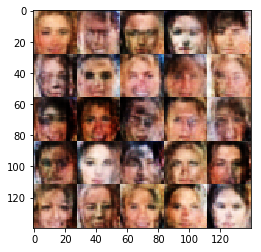

Epoch 1/1... Step 1310 Discriminator Loss: 1.2784... Generator Loss: 0.8669
Epoch 1/1... Step 1320 Discriminator Loss: 1.2684... Generator Loss: 0.8435
Epoch 1/1... Step 1330 Discriminator Loss: 1.1940... Generator Loss: 0.9415
Epoch 1/1... Step 1340 Discriminator Loss: 1.3395... Generator Loss: 0.8826
Epoch 1/1... Step 1350 Discriminator Loss: 1.3307... Generator Loss: 0.6273
Epoch 1/1... Step 1360 Discriminator Loss: 1.2037... Generator Loss: 0.9497
Epoch 1/1... Step 1370 Discriminator Loss: 1.1940... Generator Loss: 1.0253
Epoch 1/1... Step 1380 Discriminator Loss: 1.2456... Generator Loss: 0.8326
Epoch 1/1... Step 1390 Discriminator Loss: 1.2996... Generator Loss: 1.1265
Epoch 1/1... Step 1400 Discriminator Loss: 1.2641... Generator Loss: 1.3118


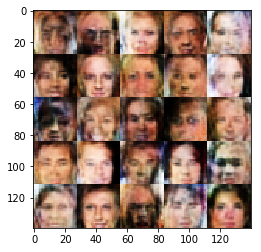

Epoch 1/1... Step 1410 Discriminator Loss: 1.2944... Generator Loss: 1.0012
Epoch 1/1... Step 1420 Discriminator Loss: 1.1467... Generator Loss: 0.9815
Epoch 1/1... Step 1430 Discriminator Loss: 1.2308... Generator Loss: 1.1709
Epoch 1/1... Step 1440 Discriminator Loss: 1.3453... Generator Loss: 0.6251
Epoch 1/1... Step 1450 Discriminator Loss: 1.2521... Generator Loss: 0.8844
Epoch 1/1... Step 1460 Discriminator Loss: 1.1541... Generator Loss: 0.9075
Epoch 1/1... Step 1470 Discriminator Loss: 1.2443... Generator Loss: 1.0773
Epoch 1/1... Step 1480 Discriminator Loss: 1.2642... Generator Loss: 1.2041
Epoch 1/1... Step 1490 Discriminator Loss: 1.3326... Generator Loss: 0.8819
Epoch 1/1... Step 1500 Discriminator Loss: 1.1518... Generator Loss: 0.9660


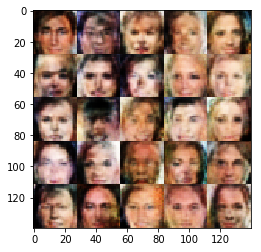

Epoch 1/1... Step 1510 Discriminator Loss: 1.1574... Generator Loss: 0.8547
Epoch 1/1... Step 1520 Discriminator Loss: 1.2859... Generator Loss: 0.6683
Epoch 1/1... Step 1530 Discriminator Loss: 1.3059... Generator Loss: 0.8249
Epoch 1/1... Step 1540 Discriminator Loss: 1.1779... Generator Loss: 1.3000
Epoch 1/1... Step 1550 Discriminator Loss: 1.2562... Generator Loss: 0.8962
Epoch 1/1... Step 1560 Discriminator Loss: 1.0841... Generator Loss: 1.0879
Epoch 1/1... Step 1570 Discriminator Loss: 1.2841... Generator Loss: 0.8106
Epoch 1/1... Step 1580 Discriminator Loss: 1.1071... Generator Loss: 1.1380


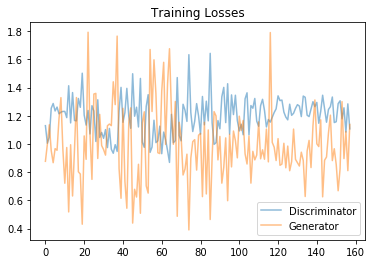

In [51]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.